# Modeling (Clustering Unit)
## Corey Solitaire
#### 10.15.2020

In [1]:
import acquire
import prepare
import wrangle
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.float_format = '{:20,.2f}'.format
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

In [2]:
#df = wrangle.get_zillow_data()
train, validate, test = wrangle.clean_zillow(wrangle.get_zillow_data()) 
train.shape, validate.shape, test.shape

((43332, 21), (18572, 21), (15476, 21))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43332 entries, 14505 to 54422
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   43332 non-null  int64   
 1   bedroomcnt                    43332 non-null  int64   
 2   calculatedfinishedsquarefeet  43332 non-null  int64   
 3   latitude                      43332 non-null  float64 
 4   longitude                     43332 non-null  float64 
 5   lotsizesquarefeet             43332 non-null  int64   
 6   rawcensustractandblock        43332 non-null  int64   
 7   regionidzip                   43332 non-null  category
 8   roomcnt                       43332 non-null  int64   
 9   unitcnt                       43332 non-null  int64   
 10  yearbuilt                     43332 non-null  int64   
 11  structuretaxvaluedollarcnt    43332 non-null  float64 
 12  taxvaluedollarcnt             43332 non-nu

#### New Dataframes based on County

In [4]:
# LA County
la_df = train[train.county=='Los Angeles']
la_df.shape

# Ventura County
vc_df = train[train.county=='Ventura']
vc_df.shape

# Orange County
oc_df = train[train.county=='Orange']

la_df.shape, vc_df.shape, oc_df.shape

((28462, 21), (3452, 21), (11418, 21))

#### Remove Outliers  using IQR, and recombining Dataframe Afterwards

In [5]:

rowData = la_df.loc[14505, : ]
rowData

bathroomcnt                                             1
bedroomcnt                                              2
calculatedfinishedsquarefeet                          936
latitude                                            34.07
longitude                                         -117.76
lotsizesquarefeet                                    4057
rawcensustractandblock                           60374023
regionidzip                                         96508
roomcnt                                                 0
unitcnt                                                 1
yearbuilt                                            1924
structuretaxvaluedollarcnt                       8,877.00
taxvaluedollarcnt                               19,208.00
assessmentyear                                       2016
landtaxvaluedollarcnt                           10,331.00
taxamount                                          413.73
censustractandblock                 60,374,023,033,004.00
logerror      

In [6]:
from scipy import stats
import numpy as np

# Must remove categorical variables before outlier elimination

# Make new dataframe from categorical variables
cat_df = la_df[["regionidzip","county","propertylandusedesc","heatingorsystemdesc"]].copy()
# remove categorical variavbles for outlier examination
la_df = la_df.drop(columns=["regionidzip","county","propertylandusedesc","heatingorsystemdesc"])


# Drop Outliers in Dataframe (Set = 3 not 1.5)
# IQR of 1.5 and 3 removed too many values, so left at 6, and still removed 5,000 Properties

Q1 = la_df.quantile(0.25)
Q3 = la_df.quantile(0.75)
IQR = Q3 - Q1

la_df_out = la_df[~((la_df < (Q1 - 6 * IQR)) |(la_df > (Q3 + 6 * IQR))).any(axis=1)]
la_df_out.shape

(23029, 17)

In [7]:
la_df = pd.concat([la_df_out, cat_df], axis=1).reindex(la_df_out.index)

In [8]:
la_df.shape

(23029, 21)

In [9]:
la_df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,regionidzip,county,propertylandusedesc,heatingorsystemdesc
14505,1.00,2.00,936.00,34.07,-117.76,"4,057.00","60,374,023.00",0.00,1.00,"1,924.00",...,"19,208.00","2,016.00","10,331.00",413.73,"60,374,023,033,004.00",-0.04,96508,Los Angeles,Single Family Residential,Floor/Wall
69608,1.00,2.00,861.00,33.85,-118.18,"7,013.00","60,375,715.00",0.00,1.00,"1,943.00",...,"305,308.00","2,016.00","244,248.00","3,778.39","60,375,715,021,000.00",0.00,96241,Los Angeles,Single Family Residential,Central
37105,3.00,4.00,"2,132.00",34.20,-118.52,"5,000.00","60,371,318.00",0.00,1.00,"1,951.00",...,"568,184.00","2,016.00","397,188.00","6,933.97","60,371,318,001,018.00",0.02,96364,Los Angeles,Single Family Residential,Central
6417,1.00,3.00,"1,368.00",33.74,-118.29,"5,625.00","60,372,962.00",0.00,1.00,"1,912.00",...,"285,417.00","2,016.00","212,207.00","3,536.60","60,372,962,103,004.00",0.01,96221,Los Angeles,Single Family Residential,Floor/Wall
16759,1.00,2.00,798.00,33.92,-118.42,"4,420.00","60,376,201.00",0.00,1.00,"1,920.00",...,"1,250,000.00","2,016.00","875,000.00","13,909.72","60,376,201,012,012.00",0.07,96103,Los Angeles,Single Family Residential,Central


***This process works, and will need to be implemented in a new function in the wrangle.py file***

***

#### Zip Codes per County

In [10]:
#Zip Codes LA

len(la_df['regionidzip'].unique()) 

279

Does LA have 280 Zipcodes? - Internet says yes, wow!

In [11]:
#Zip Codes Ventura

len(vc_df['regionidzip'].unique()) 

30

In [12]:
#Zip Codes Orange

len(oc_df['regionidzip'].unique()) 

88

***

#### Scale Data

#### Model Data

***

# Modeling Exercise:

## 1. Clustering with the Iris Dataset

**Using this lesson as a guide, perform clustering on the iris dataset.**

In [13]:
iris = sns.load_dataset('iris')

# data split
train_and_validate, test = train_test_split(iris, test_size=.1, random_state=123)
train, validate = train_test_split(train_and_validate, test_size=.1, random_state=123)

# scale
scaler = StandardScaler()
cols = ['petal_length', 'sepal_length', 'petal_width', 'sepal_width']
train_scaled = train.copy()
train_scaled[cols] = scaler.fit_transform(train[cols])

#### a. Choose features other than the ones used in the lesson.

 Clustering Formatt   
1. choose features to cluster on   
2. choose k   
3. create and fit the model   

In [14]:
# Fiting K-means object

X = train_scaled[['sepal_width', 'sepal_length']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [15]:
# Adds clusters back to dataframe
train['cluster'] = kmeans.labels_
train

,sepal_length,sepal_width,petal_length,petal_width,species,cluster
41,4.50,2.30,1.30,0.30,setosa,1
142,5.80,2.70,5.10,1.90,virginica,1
82,5.80,2.70,3.90,1.20,versicolor,1
127,6.10,3.00,4.90,1.80,virginica,1
28,5.20,3.40,1.40,0.20,setosa,2
...,...,...,...,...,...,...
29,4.70,3.20,1.60,0.20,setosa,2
52,6.90,3.10,4.90,1.50,versicolor,0
1,4.90,3.00,1.40,0.20,setosa,2
57,4.90,2.40,3.30,1.00,versicolor,1


In [16]:
# Groups all features by the clusters that were identified, then determiens the average for each feature per cluster

train.groupby('cluster').mean()

,sepal_length,sepal_width,petal_length,petal_width
cluster,,,,
0,6.86,3.11,5.47,1.88
1,5.76,2.66,4.35,1.42
2,5.08,3.47,1.54,0.29


#### b. Visualize the results of your clustering.

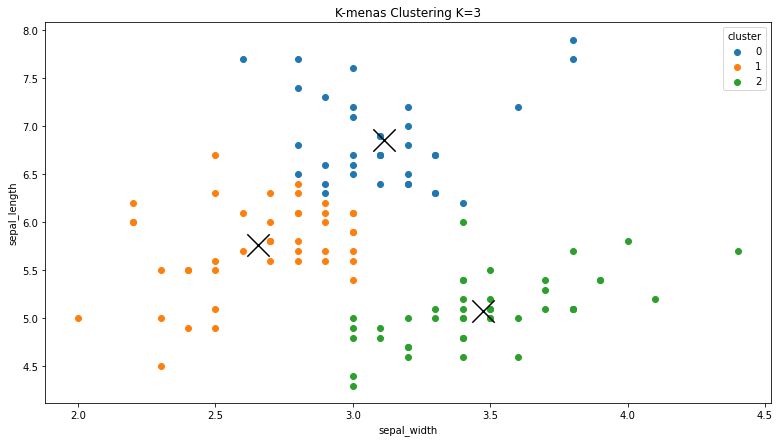

In [17]:
# Visualize seleted variables
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train.groupby('cluster'):
    ax.scatter(subset.sepal_width, subset.sepal_length, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='sepal length', xlabel='sepal width')

train.groupby('cluster').mean().plot.scatter(y='sepal_length', x='sepal_width', marker='x', s=500, ax=ax, c='black')
plt.title('K-menas Clustering K=3')
plt.show()

#### c. Use the elbow method to visually select a good value for k.

Elbow Method Demo   

1. Choose a range of k values   
2. Create a model for each k and record inertia   
3. Visualize results (k vs inertia)   



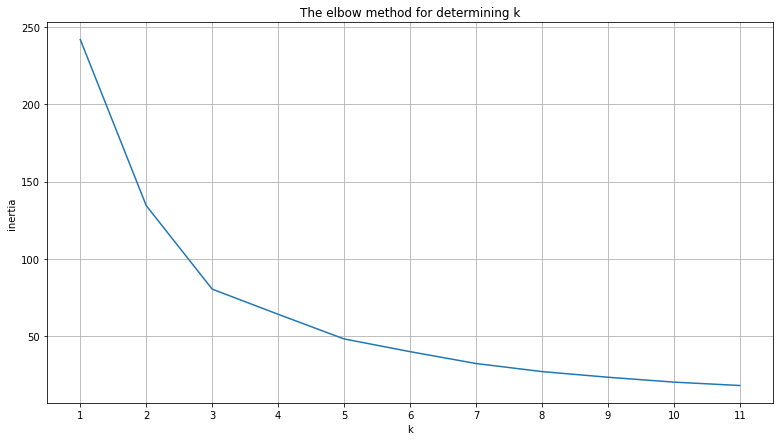

In [18]:
# Determining K using Elbow Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13, 7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1, 12), title='The elbow method for determining k')
ax.grid()

***

**Verifies that a k of three is valid for this dataset**

***

#### d. Repeat the clustering, this time with 3 different features.

In [19]:
# This time I will use all 4 features (Scaled)

X = train_scaled[['sepal_width', 'sepal_length', 'petal_length', 'petal_width']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [20]:
# Adds clusters back to dataframe
train['cluster'] = kmeans.labels_
train

,sepal_length,sepal_width,petal_length,petal_width,species,cluster
41,4.50,2.30,1.30,0.30,setosa,0
142,5.80,2.70,5.10,1.90,virginica,2
82,5.80,2.70,3.90,1.20,versicolor,2
127,6.10,3.00,4.90,1.80,virginica,1
28,5.20,3.40,1.40,0.20,setosa,0
...,...,...,...,...,...,...
29,4.70,3.20,1.60,0.20,setosa,0
52,6.90,3.10,4.90,1.50,versicolor,1
1,4.90,3.00,1.40,0.20,setosa,0
57,4.90,2.40,3.30,1.00,versicolor,2


In [21]:
# Groups all features by the clusters that were identified, then determiens the average for each feature per cluster

train.groupby('cluster').mean()

,sepal_length,sepal_width,petal_length,petal_width
cluster,,,,
0,5.04,3.45,1.47,0.26
1,6.82,3.11,5.50,1.90
2,5.78,2.67,4.35,1.41


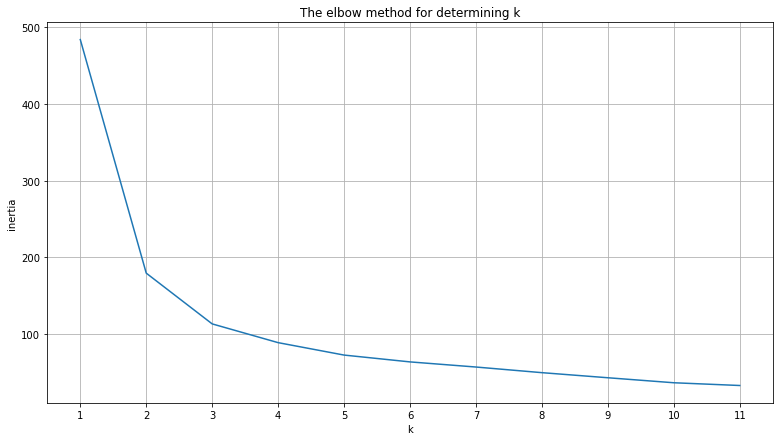

In [22]:
# Determining K using Elbow Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13, 7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1, 12), title='The elbow method for determining k')
ax.grid()

***

**Verifies that a k of three is valid for this dataset**

***

## 2. Use the techniques discussed in this lesson, as well as the insights gained from the exploration exercise to perform clustering on the mall customers dataset. Be sure to visualize your results!

In [23]:
import wrangle_mall
df = wrangle_mall.get_mall_data(cached=True)
# turn gender in to dummy variable
df = pd.get_dummies(df, columns=['gender'])
df.head()

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
0,1,19,15,39,0,1
1,2,21,15,81,0,1
2,3,20,16,6,1,0
3,4,23,16,77,1,0
4,5,31,17,40,1,0


In [24]:
df.columns

Index(['customer_id', 'age', 'annual_income', 'spending_score',
       'gender_Female', 'gender_Male'],
      dtype='object')

####  Split/Scale

In [25]:
# data split
train_and_validate, test = train_test_split(df, test_size=.1, random_state=123)
train, validate = train_test_split(train_and_validate, test_size=.1, random_state=123)

In [26]:
# scale
scaler = StandardScaler()
cols = ['age','annual_income','spending_score','customer_id']
train_scaled = train.copy()
train_scaled[cols] = scaler.fit_transform(train[cols])

In [27]:
# Visualize train_scaled
train_scaled.head()

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
12,-1.49,1.38,-1.51,-1.35,1,0
64,-0.60,1.74,-0.47,0.06,0,1
175,1.30,-0.63,1.02,1.43,1,0
87,-0.21,-1.20,-0.13,0.22,1,0
111,0.20,-1.41,0.09,0.18,1,0


***

#### Cluster   
1. choose features to cluster on   
2. choose k   
3. create and fit the model   

***

In [28]:
# I want to choose age, annual_income, spending_score and gender to cluster on

X = train_scaled[['age', 'annual_income', 'spending_score', 'gender_Female', 'gender_Male']]
kmeans = KMeans(n_clusters=4)   # Lots of variables so I will go with a k of 5 (Too high changed to 4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [29]:
# Going to take the labels I have created and added them back on the data table
train['cluster'] = kmeans.labels_
train

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male,cluster
12,13,58,20,15,1,0,2
64,65,63,48,51,0,1,2
175,176,30,88,86,1,0,1
87,88,22,57,55,1,0,0
111,112,19,63,54,1,0,0
...,...,...,...,...,...,...,...
139,140,35,74,72,1,0,1
167,168,33,86,95,1,0,1
0,1,19,15,39,0,1,0
70,71,70,49,55,0,1,2


In [30]:
# Going to take the number of observations per cluster and add them to the data table
pd.concat([
    train.groupby('cluster').mean(),
    train.groupby('cluster').size().rename('n_observations'),
], axis=1)

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male,n_observations
cluster,,,,,,,
0,53.40,24.93,39.96,60.00,0.58,0.42,45
1,160.03,32.76,85.91,80.64,0.61,0.39,33
2,64.60,53.44,45.75,39.12,0.62,0.38,52
3,161.81,40.50,87.66,18.88,0.50,0.50,32


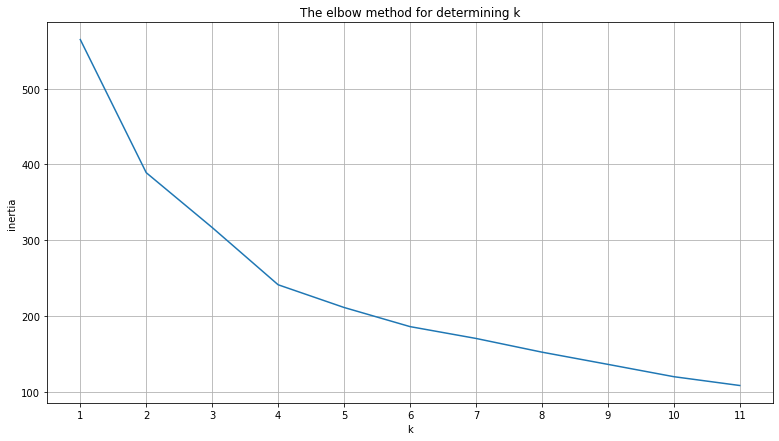

In [31]:
# Determining K using Elbow Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13, 7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1, 12), title='The elbow method for determining k')
ax.grid()

***

**Suggests that my K of 5 is to large, I am going to go back and use a k of 4 and then compare**

***

In [32]:
# Going to take the number of observations per cluster and add them to the data table
pd.concat([
    train.groupby('cluster').mean(),
    train.groupby('cluster').size().rename('n_observations'),
], axis=1)

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male,n_observations
cluster,,,,,,,
0,53.40,24.93,39.96,60.00,0.58,0.42,45
1,160.03,32.76,85.91,80.64,0.61,0.39,33
2,64.60,53.44,45.75,39.12,0.62,0.38,52
3,161.81,40.50,87.66,18.88,0.50,0.50,32


***

**Takeaway: K @ 5**
- Each cluster has roughly the same number of observations, suggests that data is evenly distributed   
- People with the lowest average spending score are females, about 47 years old, that make 27K a year   
- People with the hight spending score are females, about 32 years old, with an annual income of 86K a year   
- Females appear to have the highest spending score, regardless of other features   

***

**Takeaway: K @ 4**    
- distribution is still good   
- Lowest Spending Score - People around 40 with incomes ~ 87K    * Different
- Highest Spending SCore - Females around 33 with incomes ~ 86K  * Same  
- Females appear to have the highest spending score, regardless of other features * Same

***

#### Final Visualizations:

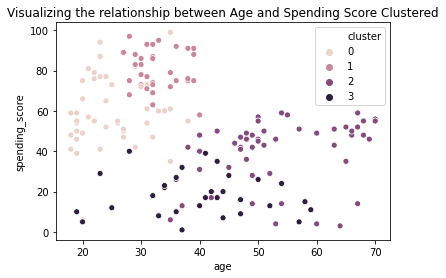

In [33]:
# How age affects spending score

sns.scatterplot(x='age', y='spending_score',
               data=train, hue='cluster')
plt.title("Visualizing the relationship between Age and Spending Score Clustered")
plt.show()

**Still a lot of overlap between clusters**

***

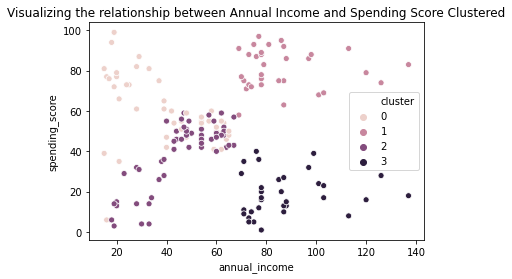

In [34]:
# How income affects spending score

sns.scatterplot(x='annual_income', y='spending_score',
               data=train, hue='cluster')
plt.title("Visualizing the relationship between Annual Income and Spending Score Clustered")
plt.show()

**This is the relationship that is best predicted by clustering**

***

## 3. How does scaling impact the results of clustering?

**Compare k-means clustering results on scaled and unscaled data. You can show how the resulting clusters differ either with descriptive statistics or visually.**

In [38]:
train.head()

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male,cluster
12,13,58,20,15,1,0,1
64,65,63,48,51,0,1,1
175,176,30,88,86,1,0,0
87,88,22,57,55,1,0,3
111,112,19,63,54,1,0,3


In [35]:
# Clustering on Non-Scaled Data

X = train[['age', 'annual_income', 'spending_score', 'gender_Female', 'gender_Male']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [36]:
# Going to take the labels I have created and added them back on the data table
train['cluster'] = kmeans.labels_
train

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male,cluster
12,13,58,20,15,1,0,1
64,65,63,48,51,0,1,1
175,176,30,88,86,1,0,0
87,88,22,57,55,1,0,3
111,112,19,63,54,1,0,3
...,...,...,...,...,...,...,...
139,140,35,74,72,1,0,0
167,168,33,86,95,1,0,0
0,1,19,15,39,0,1,3
70,71,70,49,55,0,1,1


In [37]:
# Going to take the unscaled number of observations per cluster and add them to the data table
pd.concat([
    train.groupby('cluster').mean(),
    train.groupby('cluster').size().rename('n_observations'),
], axis=1)

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male,n_observations
cluster,,,,,,,
0,160.03,32.76,85.91,80.64,0.61,0.39,33
1,62.57,52.48,44.74,38.43,0.63,0.37,54
2,161.81,40.50,87.66,18.88,0.50,0.50,32
3,55.42,24.81,40.95,61.84,0.56,0.44,43


***

**Takeaway: K @ 5**
- Each cluster has roughly the same number of observations, suggests that data is evenly distributed   
- People with the lowest average spending score are females, about 47 years old, that make 27K a year   
- People with the hight spending score are females, about 32 years old, with an annual income of 86K a year   
- Females appear to have the highest spending score, regardless of other features   

***

**Takeaway: K @ 4**    
- distribution is still good   
- Lowest Spending Score - People around 40 with incomes ~ 87K    **Different**
- Highest Spending SCore - Females around 33 with incomes ~ 86K  **Same**  
- Females appear to have the highest spending score, regardless of other features **Same**

***

**Takeaway: Unscaled**
- distribution is still good
- Lowest Spending Score - People around 40 with incomes ~ 87K  **SAME**
- Highest Spending Score - Females around 33 with incomes ~ 86K  **Same** 
- Females appear to have the highest spending score, regardless of other features **Same**
**Unscaled data did not seem to have any affect on outcome**